# Electromiografía: Análisis de los registros agonistas y antagonistas.

## Flores Oliva Alejandro Elliot
###### Licenciatura en Física Biomédica en Ciencias Biológicas , Facultad de Ciencias, Universidad Nacional Autónoma de México.

##### Análisis elaborado por: Noel Isaías Plascencia Díaz<sup>1</sup>, Mitsui Myrna Salgado Saito<sup>2</sup>, Ana Daniela del Río Pulido<sup>3</sup>, & Erin C. McKiernan<sup>4</sup>

<sup>1</sup> Licenciatura en Física, Facultad de Ciencias, Universidad Nacional Autónoma de México<br/>
<sup>2</sup> Licenciatura en Ciencias de la Tierra, Facultad de Ciencias, Universidad Nacional Autónoma de México<br/>
<sup>3</sup> Licenciatura en Física Biomédica, Facultad de Ciencias, Universidad Nacional Autónoma de México<br/>
<sup>4</sup> Departamento de Física, Facultad de Ciencias, Universidad Nacional Autónoma de México<br/>

## Índice:
[1. Resumen](#Resumen)

[2. Configuración/Diseño del notebook. ](#Configuración/Diseñodelnotebook)

[3. Extraer y graficar los datos. ](#Extraerygraficarlosdatos)

[4. Filtración de las grabaciones.](#Filtracióndelasgrabaciones)

[5. Análisis de registros mediante cuantificaciones. ](#Análisisderegistrosmediantecuantificaciones)


<a id='Resumen'></a>
## Resumen

En este repositorio se extraerán y graficaron los registros de electromiografía de los músculos agonistas/antagonistas, se uso el Filtro band-pass Butterworth, se rectifico la señal, se cálculo de envolvente, finalmente se usaron umbrales para detectar contracciones, entre otros análisis.
Todas las grabaciones de electromiografía se obtuvieron utilizando Backyard Brains EMG Spiker Box y se guardan como archivos de audio en formato .wav, utilizando el notebook de visualización podremos abrir esta señal (los registros utilizados en este notebook son del repositorio de la Dra. Erin Christy McKiernan: https://github.com/emckiernan/electrophys).

<a id='Configuración/Diseñodelnotebook'></a>
## Configuración/Diseño del notebook

Importamos los módulos de Python para trazar figuras, gráficos en el cuaderno y crear figuras con buena resolución y etiquetas grandes.

#### Librerías utilizadas 

Importamos las librerías/ módulos que nos permitirán hacer cálculos, filtrar datos, utilizar filtros, análisis, etc.

In [86]:
import math            #Permite usar funciones matemáticas definidas en el estándar de C.
import numpy as np     #Creación de vectores y matrices multidimensionales,permite usar otras funciones matemáticas.
import scipy as sc     #Módulos para álgebra lineal, integración, interpolación, FFT, procesamiento de señales y de imagen, etc.
from scipy import signal 
from scipy.signal import butter, lfilter, filtfilt #Herramientas de procesamiento de señales, funciones de filtrado, algoritmos de interpolación.
import wave            #El módulo proporciona una interfaz para el formato de sonido WAV.
import matplotlib.pyplot as plt

#### Comandos para configuración de las imágenes/gráficos 

Configuramos para ver las figuras en notebook, creación de etiquetas, módulos para la creación de trazos.

In [87]:
#Comando para ver figuras en el cuaderno Jupyter
%matplotlib inline 

#Módulo de trazado de importación
import matplotlib.pyplot as plt 

#Comandos para crear figuras de alta resolución con etiquetas grandes
%config InlineBackend.figure_formats = {'png', 'retina'} 
plt.rcParams['axes.labelsize'] = 18                              #Tamaño de fuente para etiquetas de figuras
plt.rcParams['axes.titlesize'] = 20                              #Tamaño de fuente para títulos de figuras
plt.rcParams['font.size'] = 16                                   #Tamaño de fuente para números de figura
plt.rcParams['lines.linewidth'] = 1.6                            #Ancho de línea para trazar

<a id='Extraerygraficarlosdatos'></a>
## Extraer y graficar los datos

Las grabaciones de EMG se obtuvieron utilizando Backyard Brains EMG Spiker Box y se guardan como archivos de audio en formato .wav. Utilizando las librerías para visualizar nuestros datos, posteriormente con el uso de otros comandos almacenaremos los resultados relevantes para los cálculos/ análisis posteriores.

In [106]:
def EMG(archivo):
    
    # Visualización del archivo .wav, es necesario saber la ubicación del archivo y su nombre.
    #Los archivos WAV contienen una secuencia de bits que representan los datos de audio sin procesar.
    record = wave.open(archivo)
    
    #Obtención del número de canales, frecuencia de muestreo, número de fotogramas. 
    NumCanales = record.getnchannels()      #Número de canales y retorna el número de canales de audio. 
    N= record.getnframes()                  #Número de fotogramas.
    FrecMuestreo = record.getframerate()    #Retorna la frecuencia del muestreo.
    AnchoMuestra=record.getsampwidth()      #Retorna el ancho de la muestra en bytes.
    
    #Análisis de datos del archivo .wav
    dstr = record.readframes(N * NumCanales) #Lee y retorna como máximo n cuadros de audio, como un objeto bytes.
    waveData = np.frombuffer(dstr, np.int16) #np.frombuffer es una función para crear una matriz unidimensional utilizando un búfer. 
    #El módulo de ondas "wave" proporciona una interfaz conveniente para el formato de sonido WAV. 
    
    #Imprimimos el número de canales, la frecuencia de muestreo y el ancho de muestra.
    print('La grabación tiene %d canal(ó canales).' % (NumCanales))
    print('La frecuencia de muestreo de la grabación es %d Hz.' % (FrecMuestreo))
    print('La grabación tiene un ancho de muestra de %d' % (AnchoMuestra))
    
    #Calcular la ventana, se utiliza la función linspace para crear matrices con valores espaciados uniformemente, esta 
    #función utiliza una matriz con 5 valores que se encuentren entre 0 y 2.
    EMGtiempo=np.linspace(0, len(waveData)/FrecMuestreo, num=len(waveData))
    
    #Calcular la frecuencia.
    frec = 1/np.mean(np.diff(EMGtiempo))
    
    #Filtro Butterworth de paso de banda a 10-400Hz.
    b, a = butter(2, ([10, 400]/(frec/2)), btype = 'bandpass')
    dataf = filtfilt(b, a, waveData)
    
    #Rectificar la señal EMG filtrada.
    AbsSeñal = np.absolute(dataf)
    Abstiempo=np.linspace(0, len(AbsSeñal)/FrecMuestreo, num=len(AbsSeñal))
    
        
    #Filtro Butterworth de paso bajo para detección de envolvente.
    lowp = 8
    sfrec = FrecMuestreo
    low_pass = lowp/sfrec
    b, a = sc.signal.butter(4, low_pass, btype='lowpass')
    datafrle = filtfilt(b, a, AbsSeñal)
    
    
    #Guardamos los datos más relevantes en una matriz.
    SeñalRelevante={'FrecMuestreo':FrecMuestreo,\
        'waveData':waveData,\
        'EMGtiempo':EMGtiempo,\
        'frec':frec,\
        'dataf':dataf,\
        'AbsSeñal':AbsSeñal,\
        'Abstiempo':Abstiempo,\
        'datafrle':datafrle} 
    
    #Graficamos EMG.
    plt.figure(figsize=(18,6))                                                #Tamaño de la gráfica.
    plt.title('Registro 6-Bíceps/tríceps.') #Título.
    plt.xlabel(r'Tiempo (s)')                                                 #Título del eje horizontal.
    plt.ylabel(r'Voltaje ($\mu$V)')                                           #Título del eje vertical.
    plt.plot(EMGtiempo,waveData, 'black')                                     #Color de la señal.
    plt.xlim(0,max(EMGtiempo));
    
    return SeñalRelevante

Utilizando una grabación con menos ruido experimental, abriremos la siguiente señal la cual se realizó  10 repeticiones en las que se esté contrayendo y extendiendo el brazo, haciendo cada 2 segundos el movimiento de contracción y en otros 2, llegar a la extensión, siguiendo así sucesivamente.

La grabación tiene 2 canal(ó canales).
La frecuencia de muestreo de la grabación es 10000 Hz.
La grabación tiene un ancho de muestra de 2


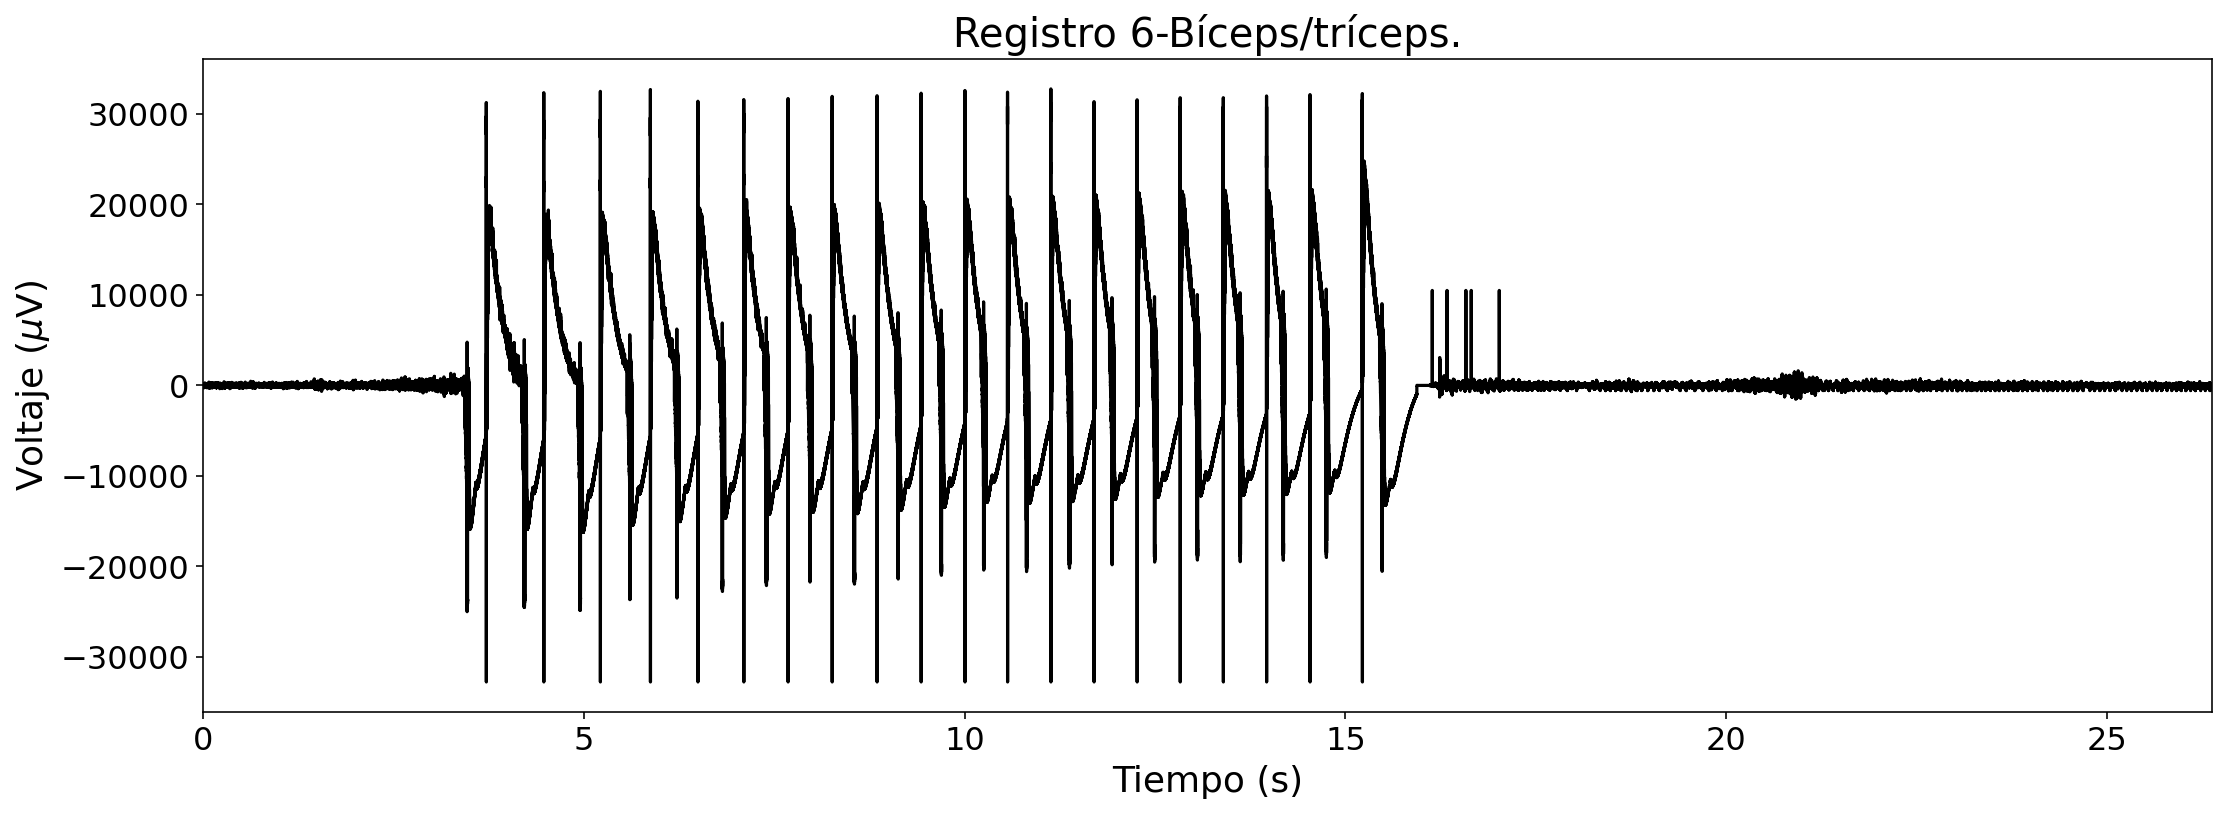

In [107]:
SeñalRelevante = EMG(archivo='../Registros/S1_EMG_bicepTricep6.wav')

<a id='Filtracióndelasgrabaciones'></a>
## Filtración de las grabaciones

La señal proveniente del registro puede tener ruido experimental o ambiental, se uso el filtro de paso banda ya que conserva las frecuencias dentro del rango especificado y excluye las frecuencias fuera del rango. Las siguientes funciones se utilizan para pasar nuestros datos sin procesar a través de un filtro de paso de banda a 10-400 Hz.

#### Filtro Butterworth de paso banda

Para el procesamiento de las señales del filtro Butterworth es un tipo de filtro de procesamiento de señal para tener una respuesta de frecuencia lo más plana posible en la banda de paso.

In [108]:
# Filtro Butterworth de paso banda a 10-400Hz.
b, a = butter(2, ([10, 400]/(SeñalRelevante['frec']/2)), btype = 'bandpass')
#[b, a] = butter (n, Wn, ftype) diseña un filtro Butterworth de paso bajo, paso alto, paso banda o supresión de banda.
#La señal depende del valor de ftype y el número de elementos de Wn.
 
dataf = filtfilt(b, a, SeñalRelevante['waveData'])
#Realiza un filtrado digital de fase cero procesando los datos de entrada “SeñalRelevante['waveData']”, tanto en la dirección directa como en la inversa.
#Después de filtrar los datos en la dirección de avance, filtfilt invierte la secuencia filtrada y la vuelve a ejecutar a través del filtro.

Trazando una ventana de tiempo con las grabaciones sin procesar (negra) y filtradas (púrpura) superpuestas, podemos ver los resultados del filtrado de paso de banda, estableciendo límites podemos enfocarnos cercanamente en ver el resultado del filtrado de la señal.

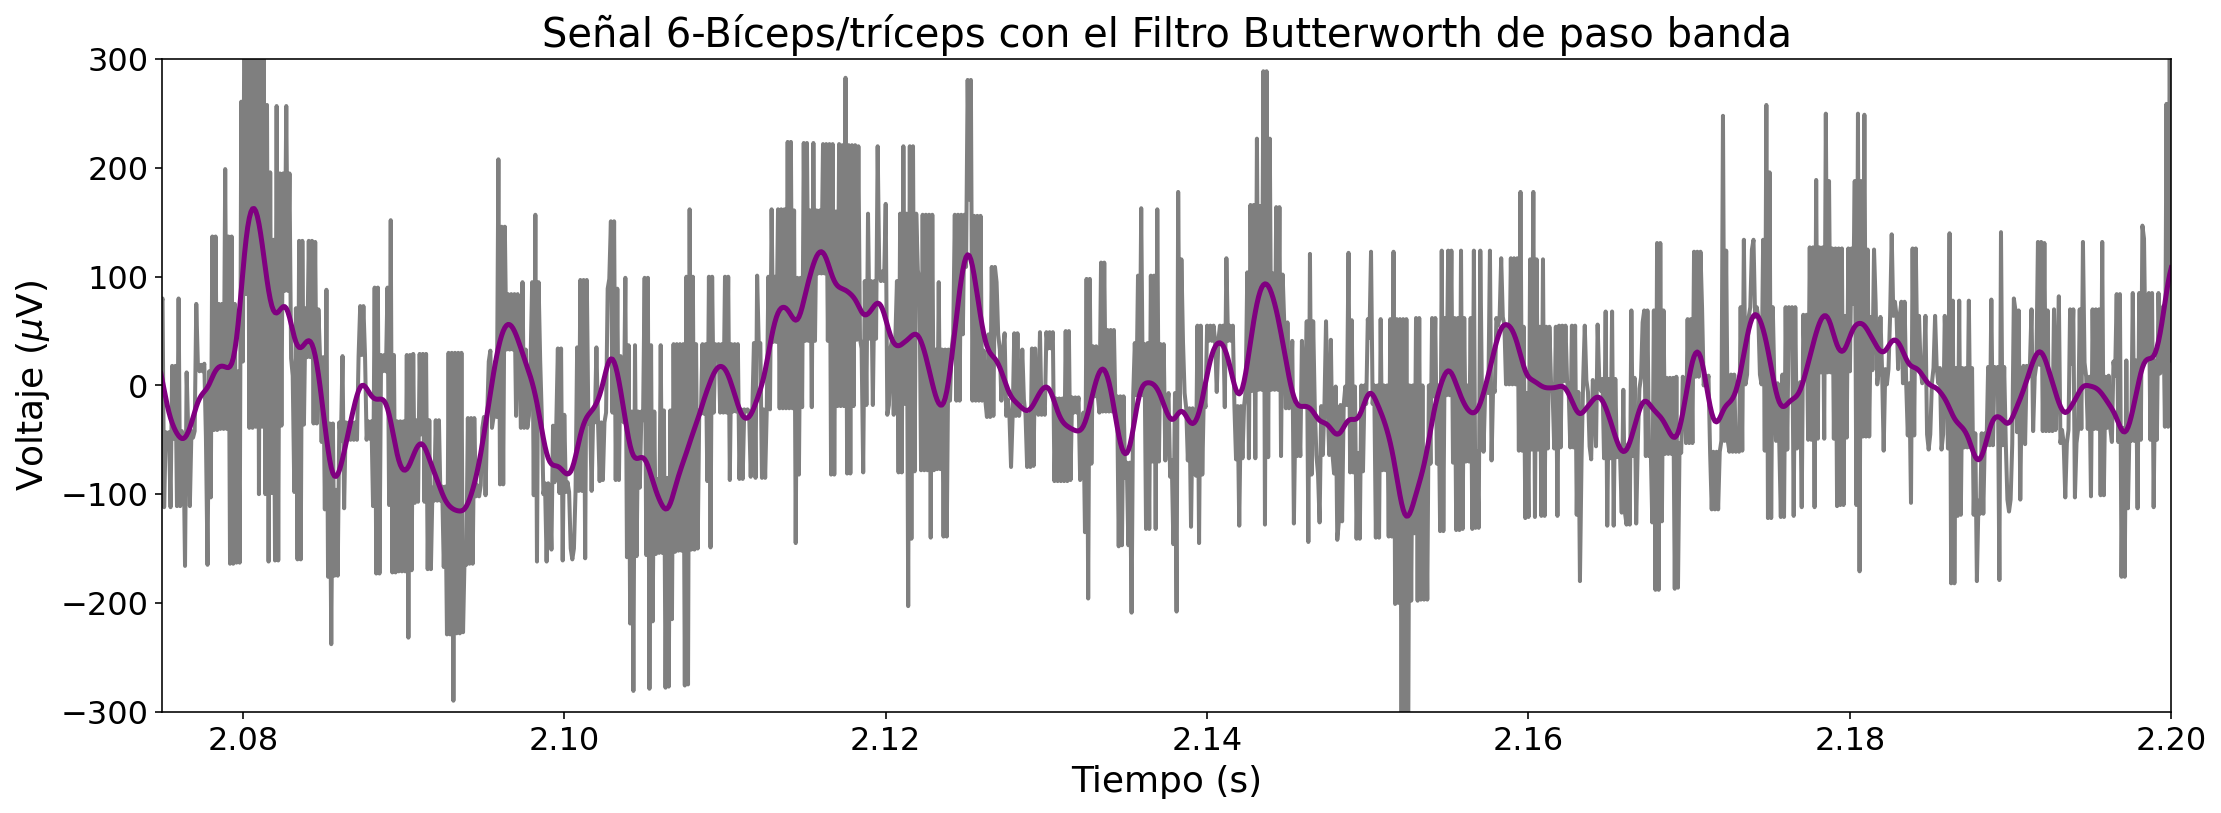

In [109]:
# Trazar la señal EMG
plt.figure(figsize=(18,6))                                               #Tamaño de la figura dibujada con Matplotlib

plt.title('Señal 6-Bíceps/tríceps con el Filtro Butterworth de paso banda') #Título.
plt.xlabel('Tiempo (s)')                                                 #Título del eje horizontal.
plt.ylabel('Voltaje ($\mu$V)')                                           #Título del eje vertical.

plt.plot(SeñalRelevante['EMGtiempo'],SeñalRelevante['waveData'], 'black', linewidth=2.0, alpha=0.5)#Trazo de la señal con color.
plt.plot(SeñalRelevante['EMGtiempo'],dataf, 'purple', linewidth=2.5)     #Trazo de la señal con color.

#Obtiene o establece los límites x de los ejes actuales.   
plt.xlim(2.075,2.2)          #Eje x                                        
plt.ylim(-300,300);       #Eje y

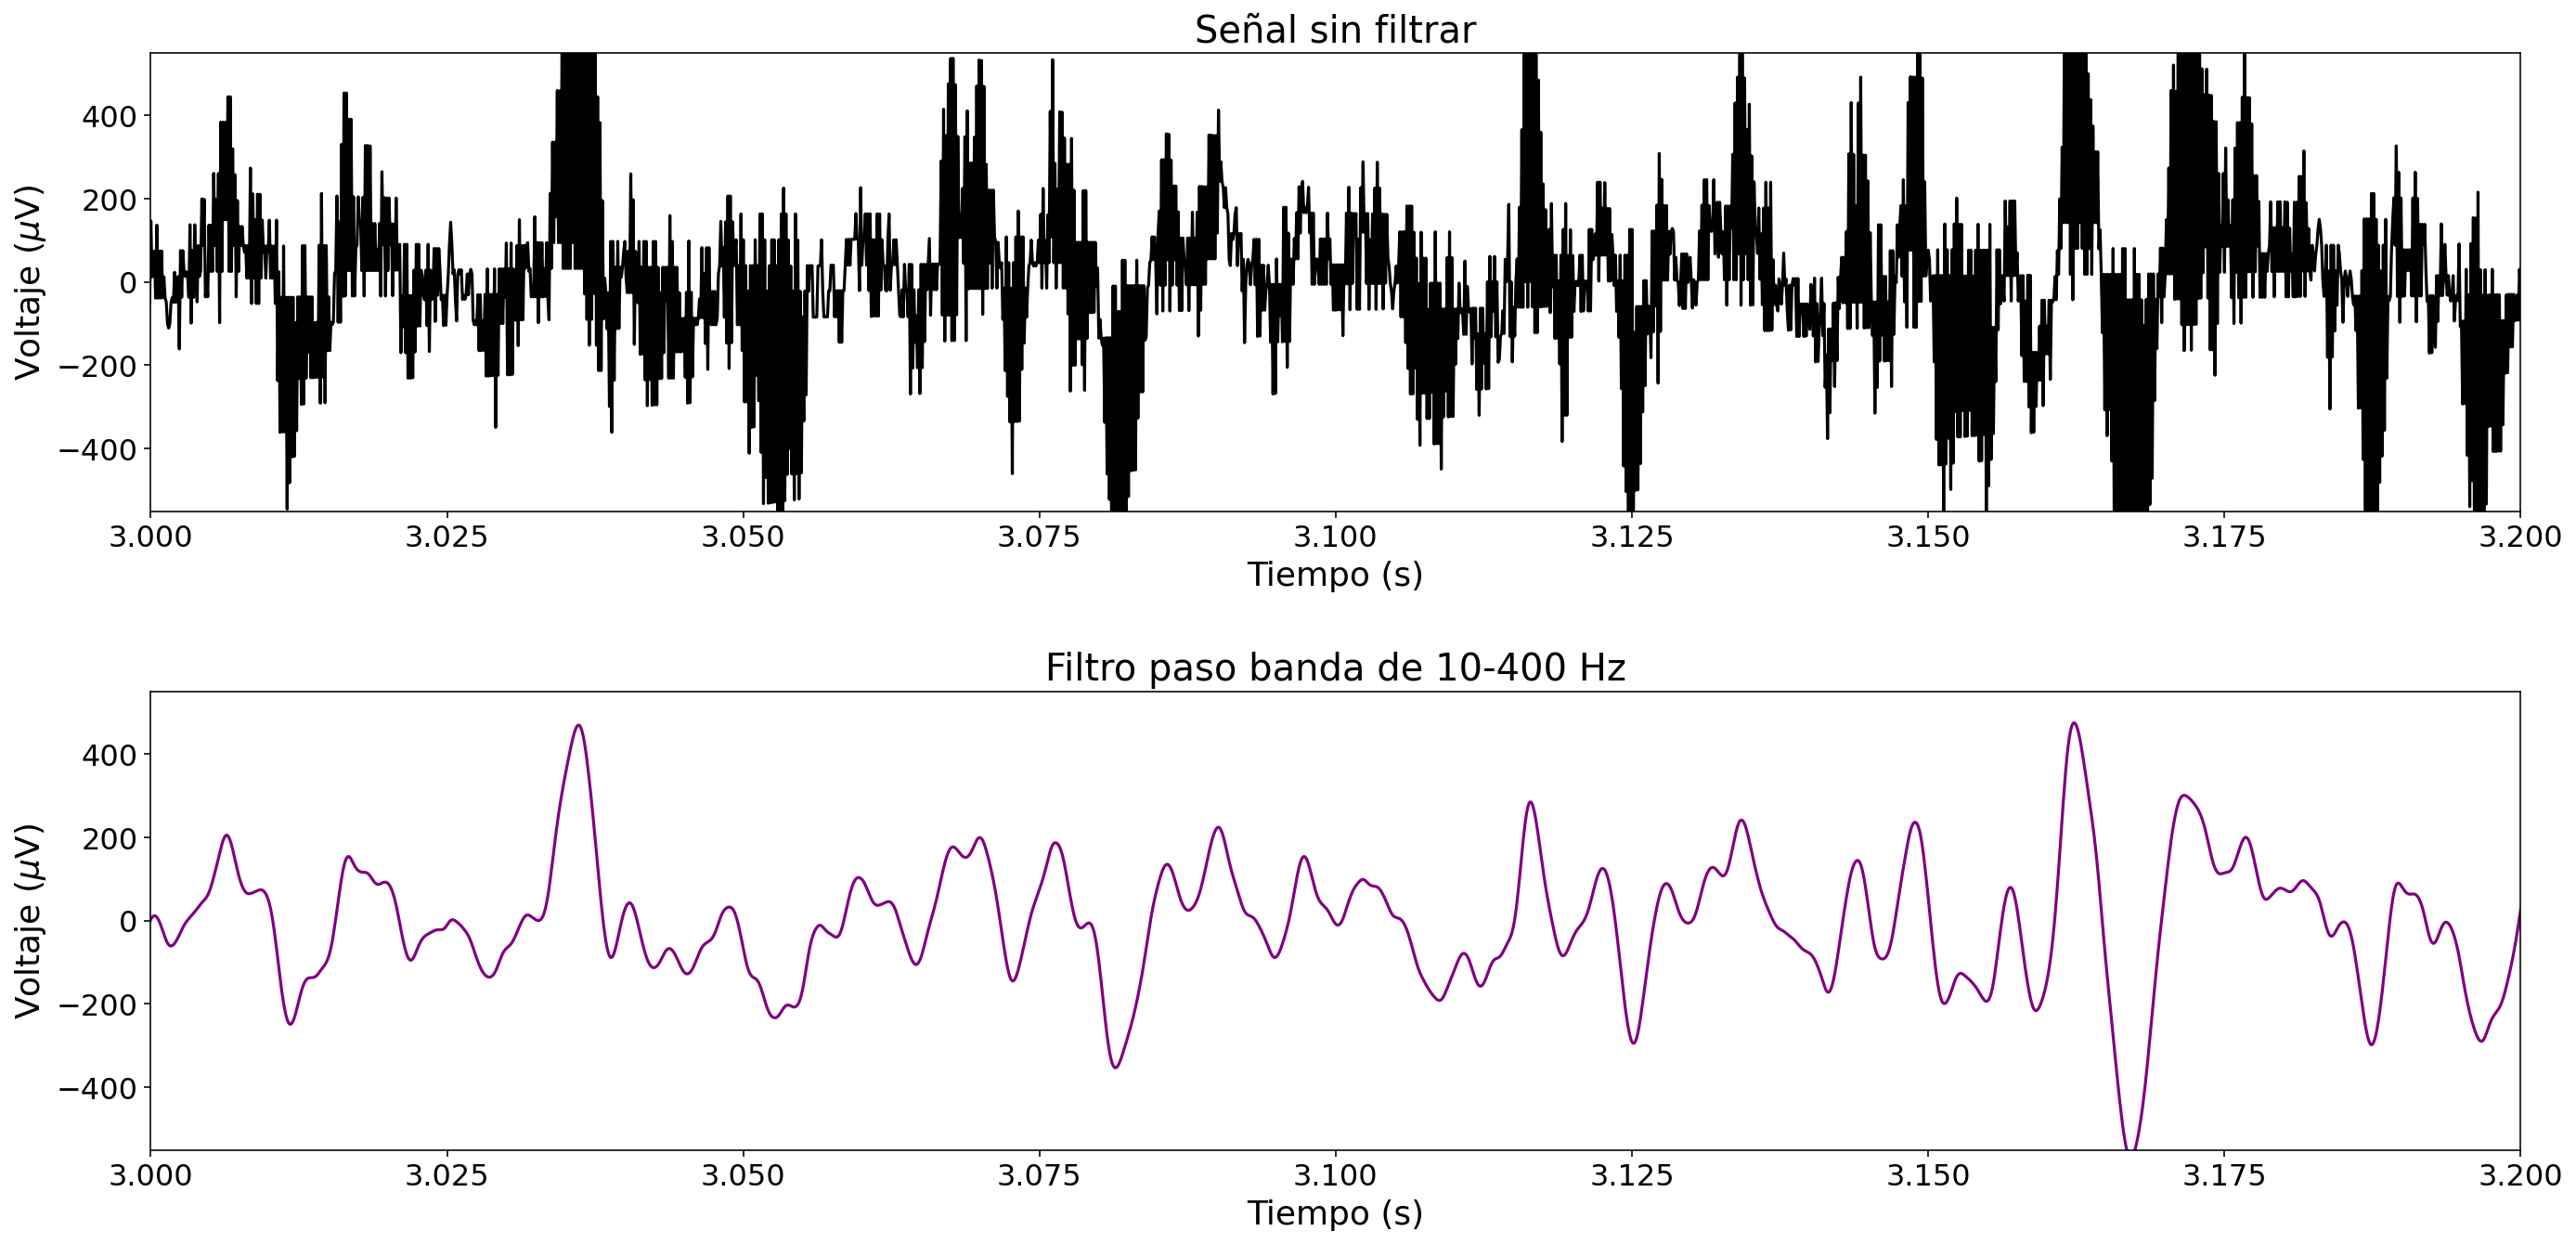

In [110]:
fig, (ax1,ax2) = plt.subplots(2, 1, sharex= False, sharey= True, figsize = (20,10))

# Trazar datos sin procesar
ax1.plot(SeñalRelevante['EMGtiempo'], SeñalRelevante['waveData'], 'black')
ax1.set_title('Señal sin filtrar', fontsize=20)
ax1.set_xlim(3.0,3.2)
ax1.set_ylim(-550,550)
ax1.set_xlabel('Tiempo (s)')
ax1.set_ylabel('Voltaje ($\mu$V)')

# Trazar datos filtrados
ax2.plot(SeñalRelevante['EMGtiempo'], dataf, 'purple')
ax2.set_title('Filtro paso banda de 10-400 Hz', fontsize=20)
ax2.set_xlim(3.0,3.2)
ax2.set_ylim(-550,550)
ax2.set_xlabel('Tiempo (s)')
ax2.set_ylabel('Voltaje ($\mu$V)')

# Espaciado entre ventanas
plt.tight_layout(pad=2.0)

#### Rectificación.

Para este análisis, se rectificó la señal electromiografia de modo que terminemos trabajando  con valores de voltaje positivos, esto permitirá posteriormente calcular una envolvente y establecer un umbral para la detección de contracciones.

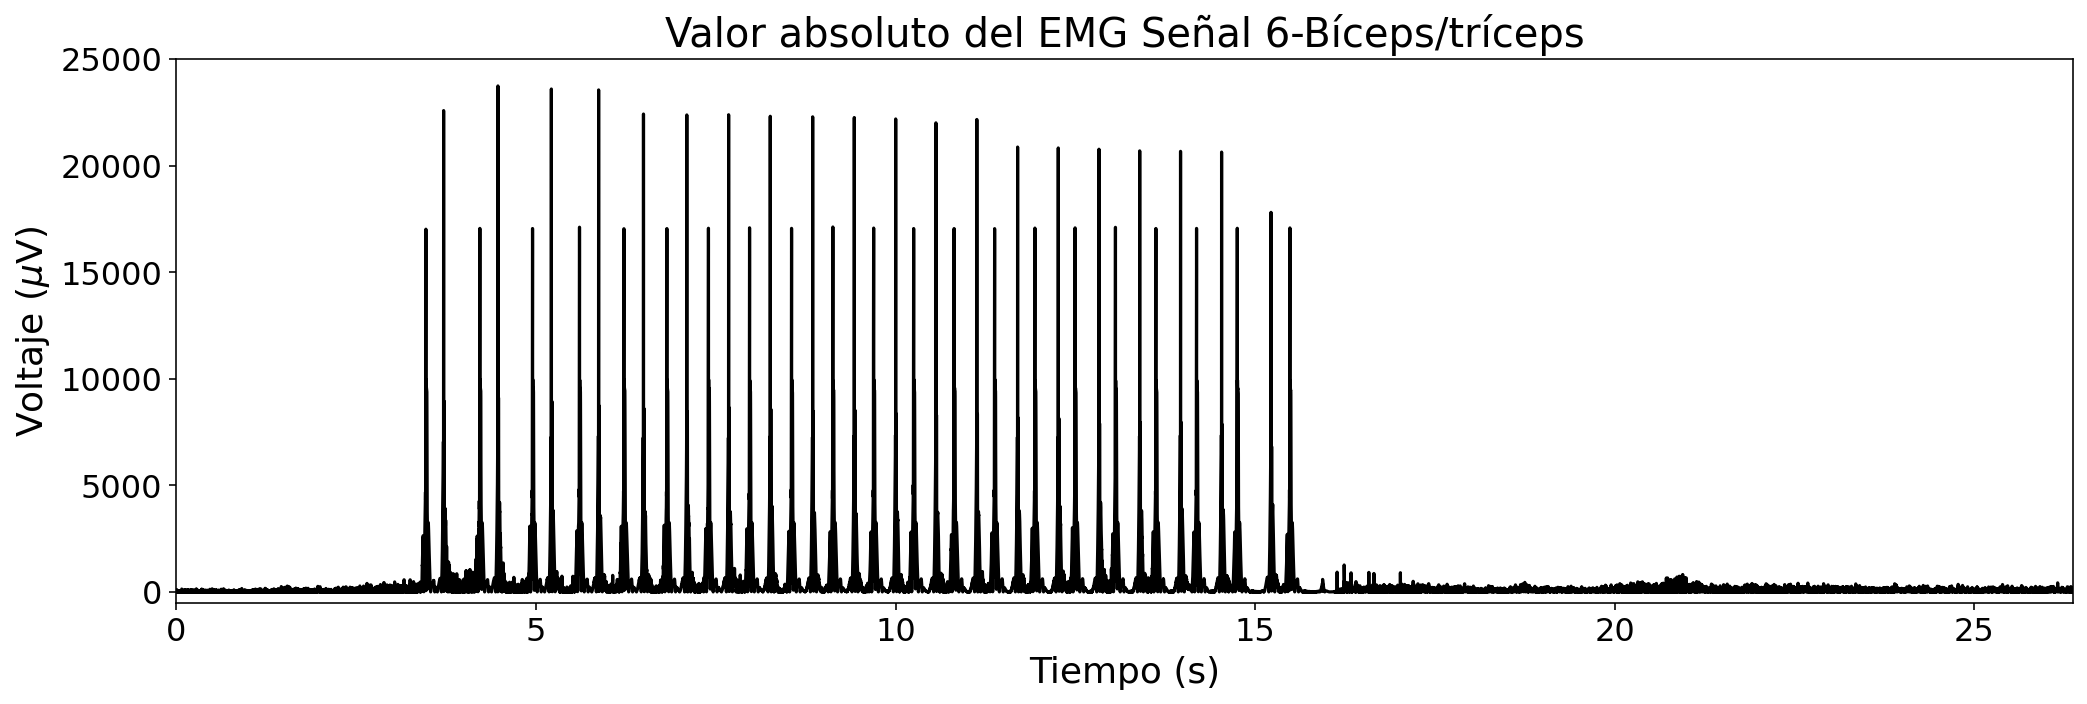

In [111]:
#Correr este código dependiendo de la función en este caso fue con SeñalRelevante, pero no correr el código de los otros ejemplos: SeñalRelevante2 & SeñalRelevante3
#para obtener los resultados de una sola señal desada y no de otra.

# Rectificar la señal EMG
AbsSeñal = np.absolute(dataf) #Calcula el valor absoluto por elementos.
Abstiempo=np.linspace(0, len(AbsSeñal)/SeñalRelevante['FrecMuestreo'], num=len(AbsSeñal))

# Trazar datos rectificados
plt.figure(figsize=(17,5))                                          #Tamaño de la gráfica.
plt.title('Valor absoluto del EMG Señal 6-Bíceps/tríceps') #Título.
plt.xlabel(r'Tiempo (s)')                                           #Título del eje horizontal.
plt.ylabel(r'Voltaje ($\mu$V)')                                     #Título del eje vertical.
plt.plot(SeñalRelevante['EMGtiempo'],AbsSeñal,'black')              #Graficación y color de la señal.
plt.xlim(0,max(SeñalRelevante['EMGtiempo']))
plt.ylim(-500,25000)
plt.show()

Podemos determinar la envolvente de la señal rectificada. Una forma de hacerlo es aplicar un filtro Butterworth de paso bajo, en este caso con un corte de 8Hz.

In [112]:
# Filtro Butterworth de paso bajo para detección de envolvente
lowp = 8     
sfrec = SeñalRelevante['FrecMuestreo']
low_pass = lowp/sfrec
b, a = sc.signal.butter(4, low_pass, btype='lowpass')
datafrle = filtfilt(b, a, AbsSeñal)

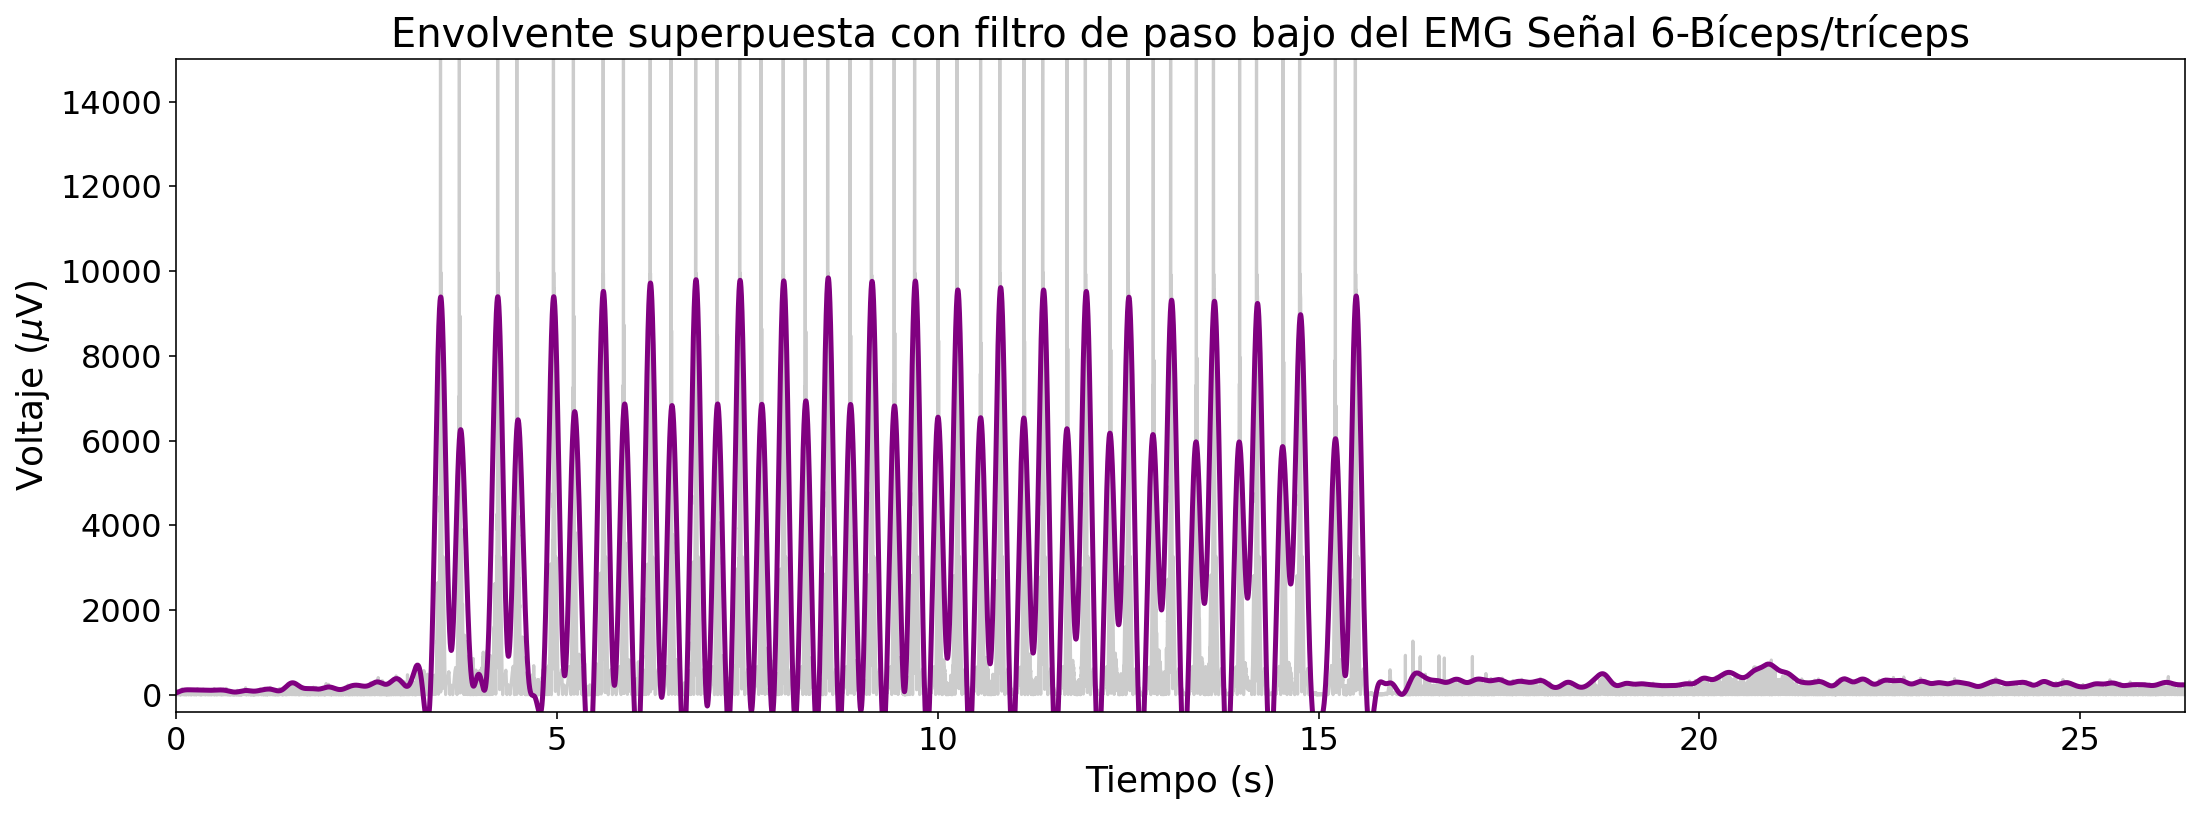

In [113]:
#Trazar señal EMG rectificada con detección de envolvente superpuesta con filtro de paso bajo
plt.figure(figsize=(18,6))
plt.title('Envolvente superpuesta con filtro de paso bajo del EMG Señal 6-Bíceps/tríceps')
plt.xlabel('Tiempo (s)')
plt.ylabel('Voltaje ($\mu$V)')
plt.plot(Abstiempo,AbsSeñal, 'gray', alpha=0.4)
plt.plot(Abstiempo,datafrle*3, 'purple', linewidth=2.5) 
plt.xlim(0,max(SeñalRelevante['EMGtiempo']))
plt.ylim(-400,15000);

<a id='Análisisderegistrosmediantecuantificaciones'></a>
## Análisis de registros mediante cuantificaciones 

La actividad muscular se puede registrar mediante la electromiografía, aunque también es útil conocer los tiempos de inicio y finalización de las contracciones, mediante la cuantificación de las duraciones de las contracciones nos permitirá entender las variaciones de las grabaciones, estas cuantificaciones ayudarán a conocer si las contracciones tienen la misma duración o ver cuánto varían en una grabación, también una de las preguntas de investigación es conocer si podemos cuantificar cuánto tiempo un sujeto es capaz de mantener una contracción sostenida y luego cuantificar cómo cambia esto en ensayos repetidos, ambas cuantificaciones podrían permitirnos observar cómo determinados ejercicios inducen la fatiga muscular.

#### Detección de los tiempos de inicio y finalización de la contracción muscular

Si trazamos solo la envolvente del EMG (no la señal multiplicada superpuesta al EMG rectificado), podemos estimar el valor apropiado para utilizarlo como umbral para detectar los tiempos de inicio y finalización de la contracción muscular.
 Con un valor lo suficientemente bajo que incluya la mayor parte de la contracción, pero lo suficientemente grande como para descartar el ruido y  las pequeñas contracciones musculares. Para la envolvente trazada a continuación, utilizando el valor de 200 (línea discontinua). 

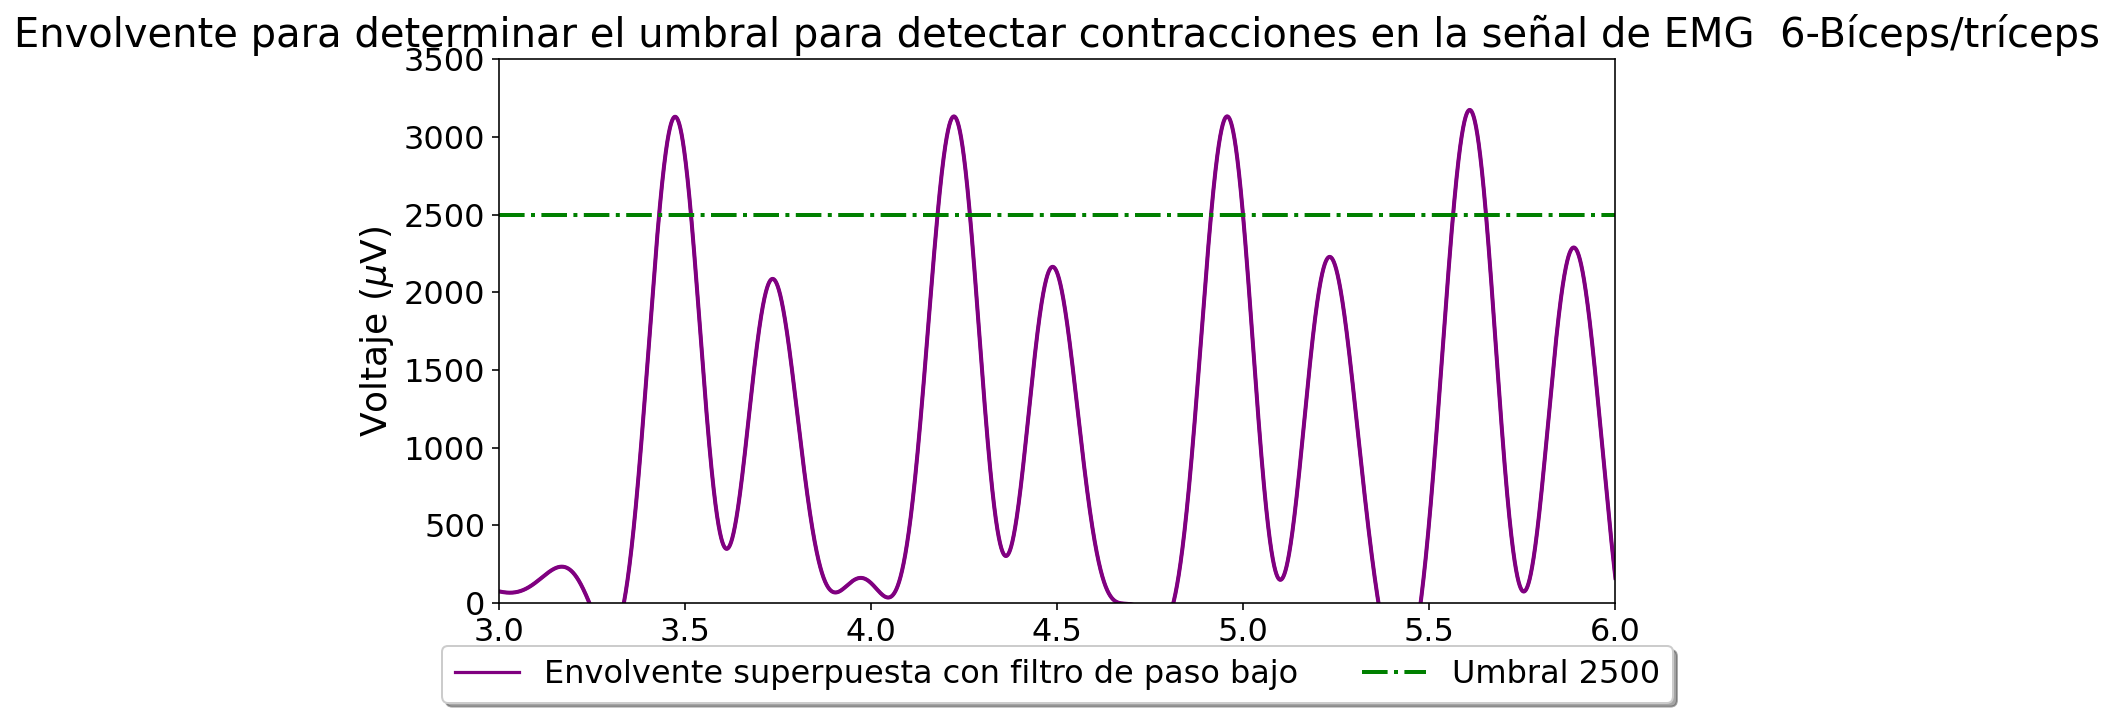

In [114]:
#Antes de trazar esta envolvente es necesario solo correr la 'Envolvente superpuesta con filtro de paso bajo del EMG del músculo
#de pantorrilla durante elevaciones repetidas con una frecuencia de corte superior a 8 Hz, o la ideal para trabajar.

#Trazar solo la envolvente para determinar el umbral para detectar contracciones
plt.figure(figsize=(10,5))
plt.title('Envolvente para determinar el umbral para detectar contracciones en la señal de EMG  6-Bíceps/tríceps')
plt.xlabel('Tiempo (s)')
plt.ylabel('Voltaje ($\mu$V)')
plt.plot(Abstiempo,datafrle, 'purple', linewidth=2.0)
plt.plot(Abstiempo,datafrle, 'purple', label = "Envolvente superpuesta con filtro de paso bajo")
plt.axhline(y=2500, color='green',linewidth=2.0, linestyle='-.', label = "Umbral 2500") #Umbral potencial
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), fancybox=True, shadow=True, ncol=5)
plt.xlim(3,6)
plt.ylim(0,3500);

##### Umbral para detectar los tiempos de inicio.

In [115]:
threshold = 2500 #Umbral
cstarts = [] #Tiempos de inicio 
for i in range(1, len(datafrle)):
    if datafrle[i-1] < threshold and datafrle[i] >= threshold:
        cstarts.append(i)
print('Tiempo de inicio del umbral:')       
print(cstarts) 

Tiempo de inicio del umbral:
[34294, 41779, 49132, 55638, 61802, 67787, 73587, 79321, 85157, 90920, 96600, 102194, 107813, 113453, 119057, 124659, 130271, 135897, 141556, 147228, 154506]


##### Umbral para detectar los tiempos de finalización.

In [116]:
threshold = 2500 #Umbral
cstops = [] #Tiempos de finaclización
for i in range(1, len(datafrle)):
    if datafrle[i-1] >= threshold and datafrle[i] < threshold:
        cstops.append(i)
print('Tiempo de finalización del umbral:')         
print(cstops)

Tiempo de finalización del umbral:
[35150, 42648, 49989, 56521, 62716, 68701, 74488, 80218, 86064, 91811, 97495, 103056, 108687, 114320, 119924, 125508, 131115, 136740, 142393, 148020, 155366]


##### Dividimos los tiempos de inicio y finalización por la frecuencia de muestreo para obtener los tiempos en segundos.

In [117]:
starts=[]
for n in range(0, len(cstarts)):
    starttime = cstarts[n]/SeñalRelevante['FrecMuestreo']
    starts.append(starttime)
print('Inicio:')     
print(starts)

stops=[]
for n in range(0, len(cstops)):
    stoptime = cstops[n]/SeñalRelevante['FrecMuestreo']
    stops.append(stoptime)
print('Final:')     
print(stops)

Inicio:
[3.4294, 4.1779, 4.9132, 5.5638, 6.1802, 6.7787, 7.3587, 7.9321, 8.5157, 9.092, 9.66, 10.2194, 10.7813, 11.3453, 11.9057, 12.4659, 13.0271, 13.5897, 14.1556, 14.7228, 15.4506]
Final:
[3.515, 4.2648, 4.9989, 5.6521, 6.2716, 6.8701, 7.4488, 8.0218, 8.6064, 9.1811, 9.7495, 10.3056, 10.8687, 11.432, 11.9924, 12.5508, 13.1115, 13.674, 14.2393, 14.802, 15.5366]


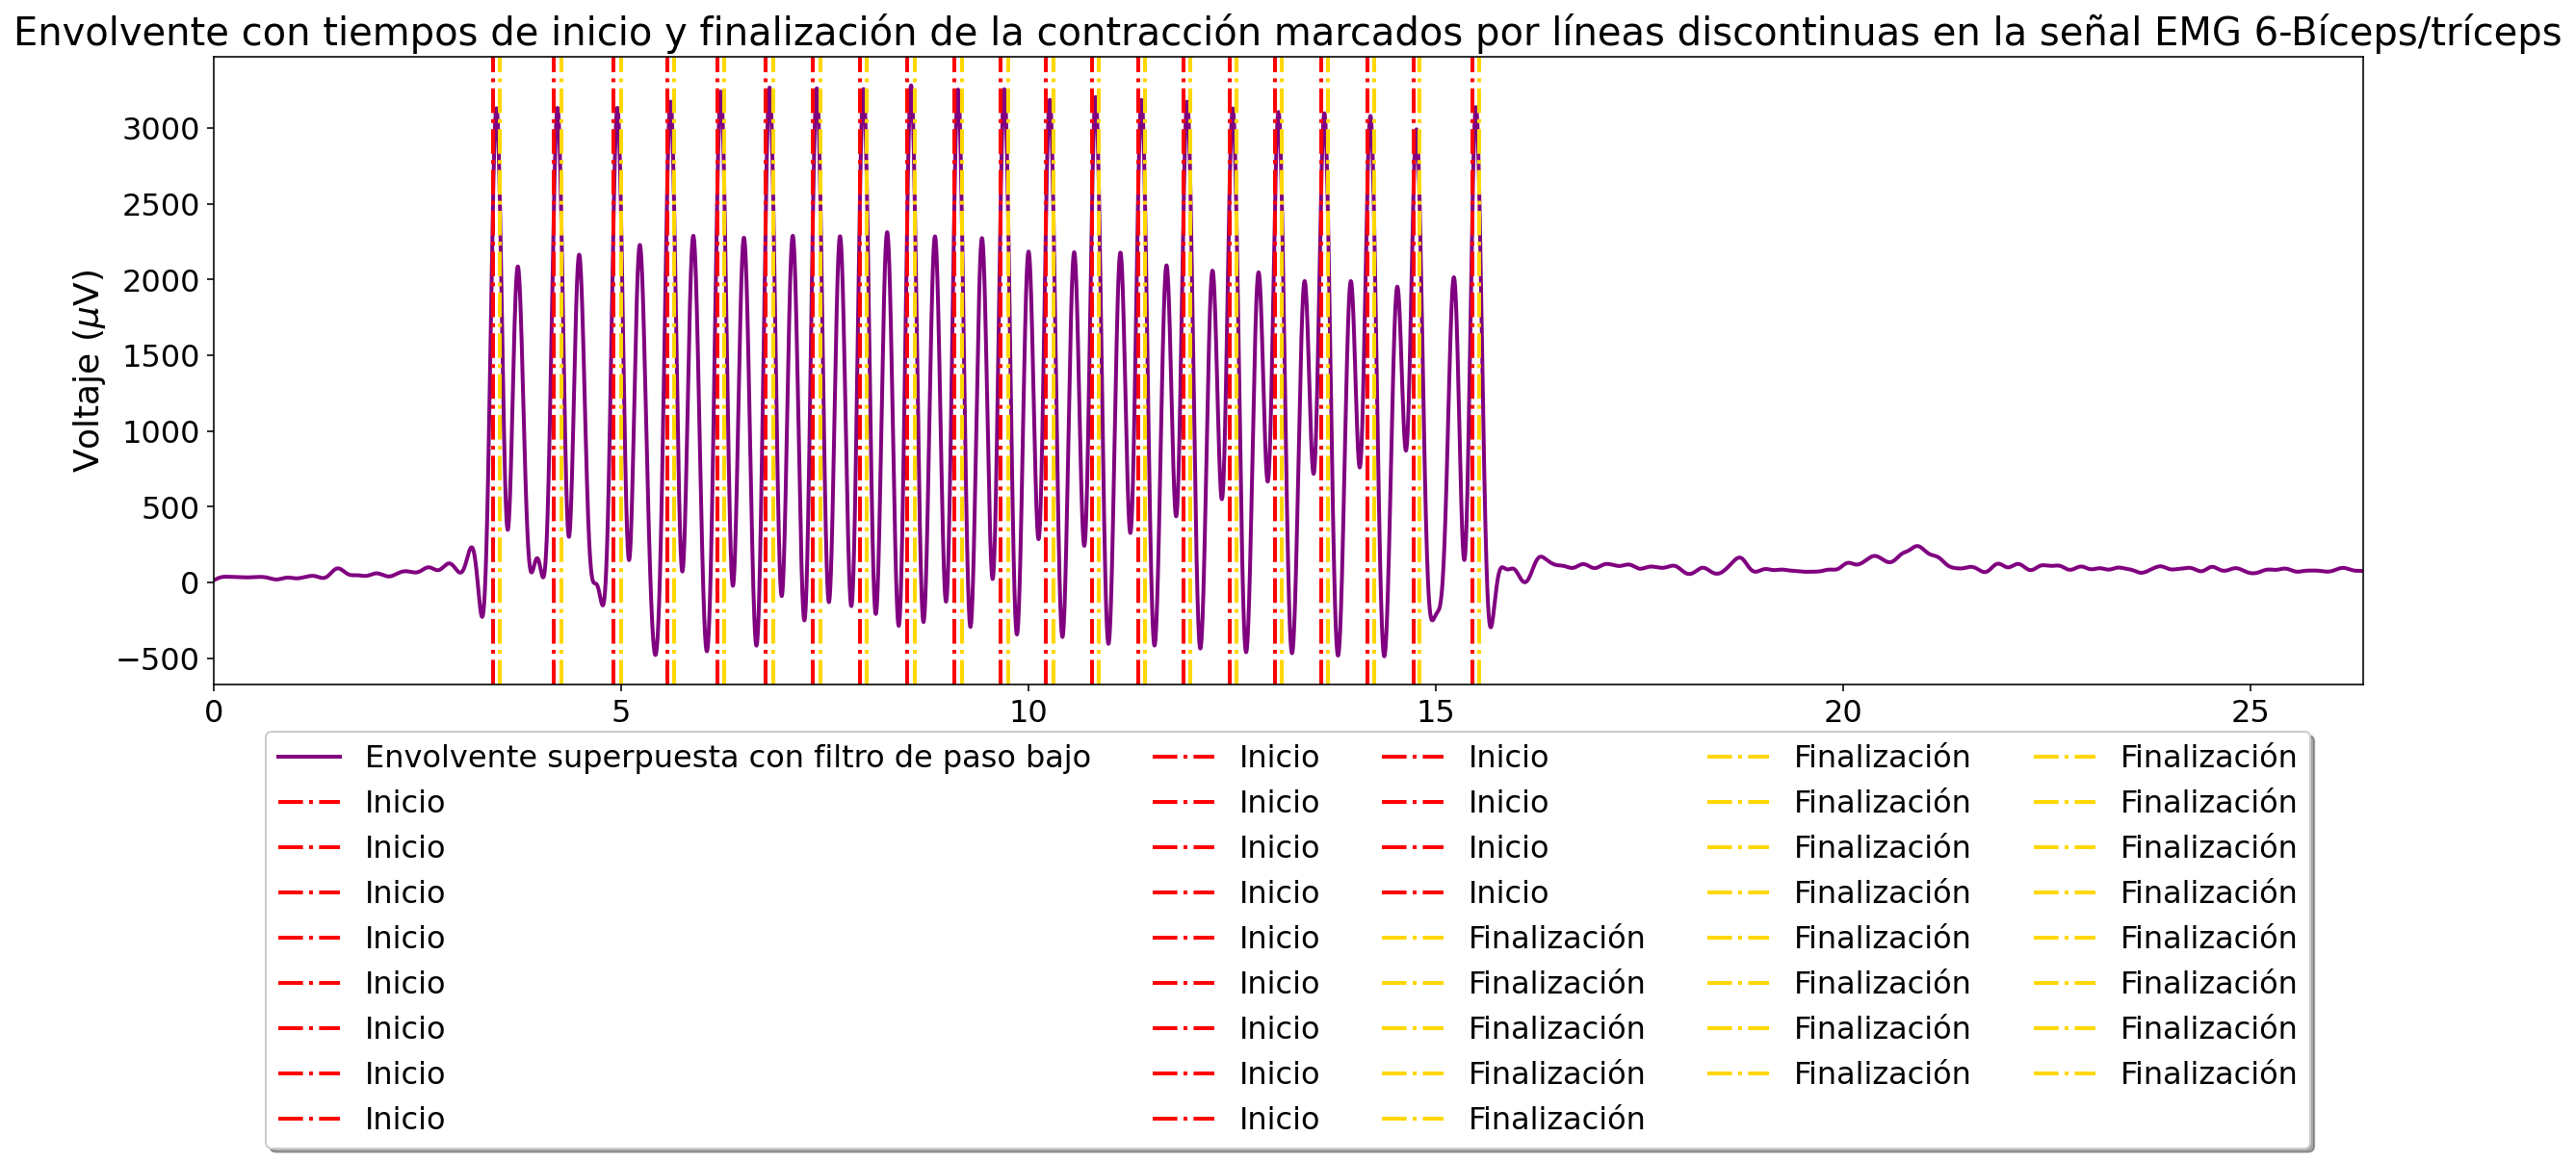

In [118]:
#Trazar envolvente con tiempos de inicio y finalización de la contracción marcados por líneas discontinuas
plt.figure(figsize=(20,6))
plt.title('Envolvente con tiempos de inicio y finalización de la contracción marcados por líneas discontinuas en la señal EMG 6-Bíceps/tríceps')
plt.xlabel('Tiempo (s)')
plt.ylabel('Voltaje ($\mu$V)')
plt.plot(Abstiempo, datafrle, 'purple', linewidth=2.0, label = "Envolvente superpuesta con filtro de paso bajo")

#Para la detección de tiempo de inicio.
for n in range(0, len(starts)):
    plt.axvline(x=starts[n], color='red',linewidth=2.0, linestyle='-.', label="Inicio")
    
#Para la detección de tiempo de finalización.    
for n in range(0, len(stops)):
    plt.axvline(x=stops[n], color='gold',linewidth=2.0, linestyle='-.',label="Finalización")
    
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), fancybox=True, shadow=True, ncol=5)
    
    
plt.xlim(0, max(SeñalRelevante['EMGtiempo']));

In [119]:
#Calcular e imprimir las duraciones de las contracciones en segundos
durs=[]
for n in range(0,len(starts)):
    durs.append(stops[n]-starts[n])
    print('Duración de las contracciones en segundos:') 
    print(round(durs[n], 4))

Duración de las contracciones en segundos:
0.0856
Duración de las contracciones en segundos:
0.0869
Duración de las contracciones en segundos:
0.0857
Duración de las contracciones en segundos:
0.0883
Duración de las contracciones en segundos:
0.0914
Duración de las contracciones en segundos:
0.0914
Duración de las contracciones en segundos:
0.0901
Duración de las contracciones en segundos:
0.0897
Duración de las contracciones en segundos:
0.0907
Duración de las contracciones en segundos:
0.0891
Duración de las contracciones en segundos:
0.0895
Duración de las contracciones en segundos:
0.0862
Duración de las contracciones en segundos:
0.0874
Duración de las contracciones en segundos:
0.0867
Duración de las contracciones en segundos:
0.0867
Duración de las contracciones en segundos:
0.0849
Duración de las contracciones en segundos:
0.0844
Duración de las contracciones en segundos:
0.0843
Duración de las contracciones en segundos:
0.0837
Duración de las contracciones en segundos:
0.0792


In [120]:
#Calcular el número de bins de 1 segundo en la grabación; 'floor' para expresar el número como entero.
nbins = math.floor(len(SeñalRelevante['waveData'])/SeñalRelevante['FrecMuestreo'])
print('La grabación tiene % d bins de 1 segundo de duración.' % (nbins))

# función para crear contenedores, adaptada de https://www.python-course.eu/pandas_python_binning.php
def createBins(lower_bound, width, quantity):
    bins = []
    for low in range(lower_bound,lower_bound + quantity*width + 1, width):
        bins.append((low, low+width))
    return bins

# ejecutar función para crear contenedores.
secBins = createBins(0,SeñalRelevante['FrecMuestreo'],nbins)

La grabación tiene  26 bins de 1 segundo de duración.


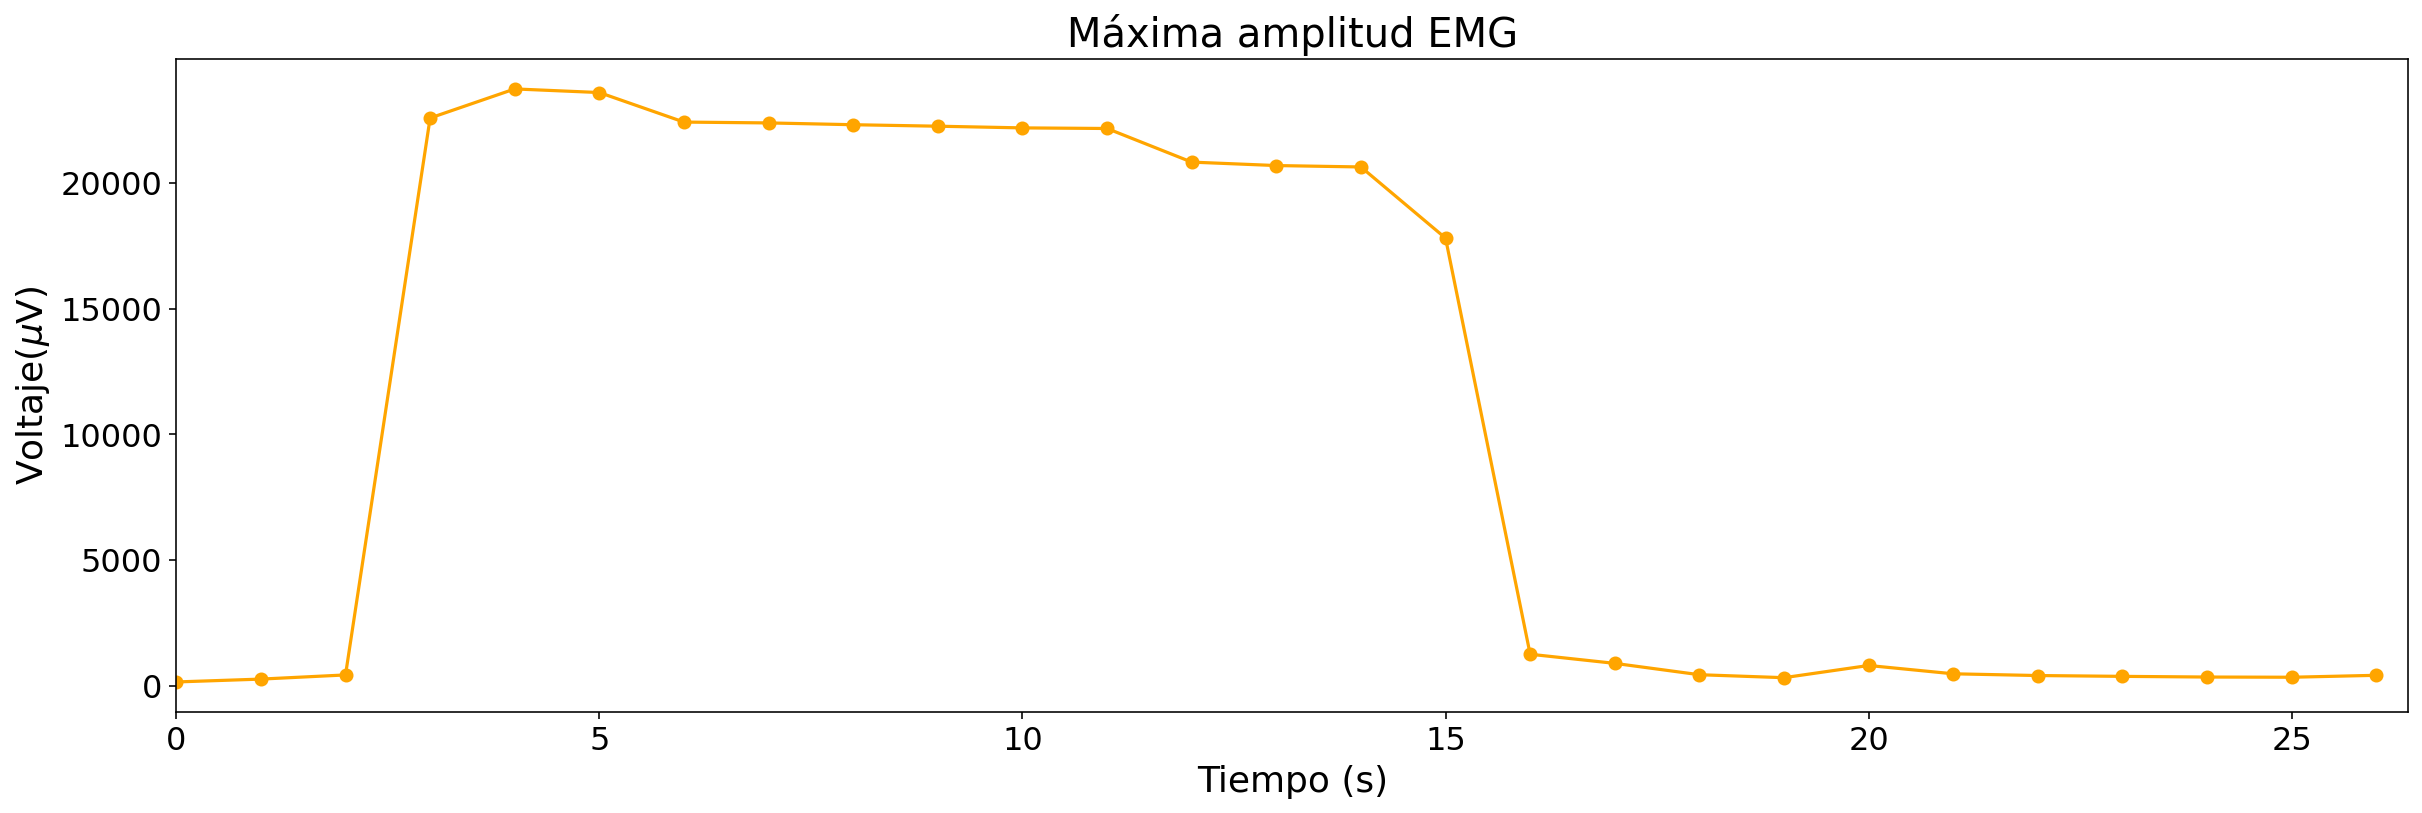

In [121]:
# Calcular la amplitud máxima sobre los contenedores
x = secBins
y = SeñalRelevante['AbsSeñal']
maxamps = []

for n in range(0,len(x)):
    maxAmp=y[min(x[n]):max(x[n])].max()
    maxamps.append(maxAmp)

# Trazamos los resultados    
plt.figure(figsize=(20,6))
plt.plot(maxamps,'o-',color='orange')
plt.title('Máxima amplitud EMG')
plt.xlabel('Tiempo (s)')
plt.xlim(0,max(SeñalRelevante['EMGtiempo']))  
plt.ylabel('Voltaje($\mu$V)');

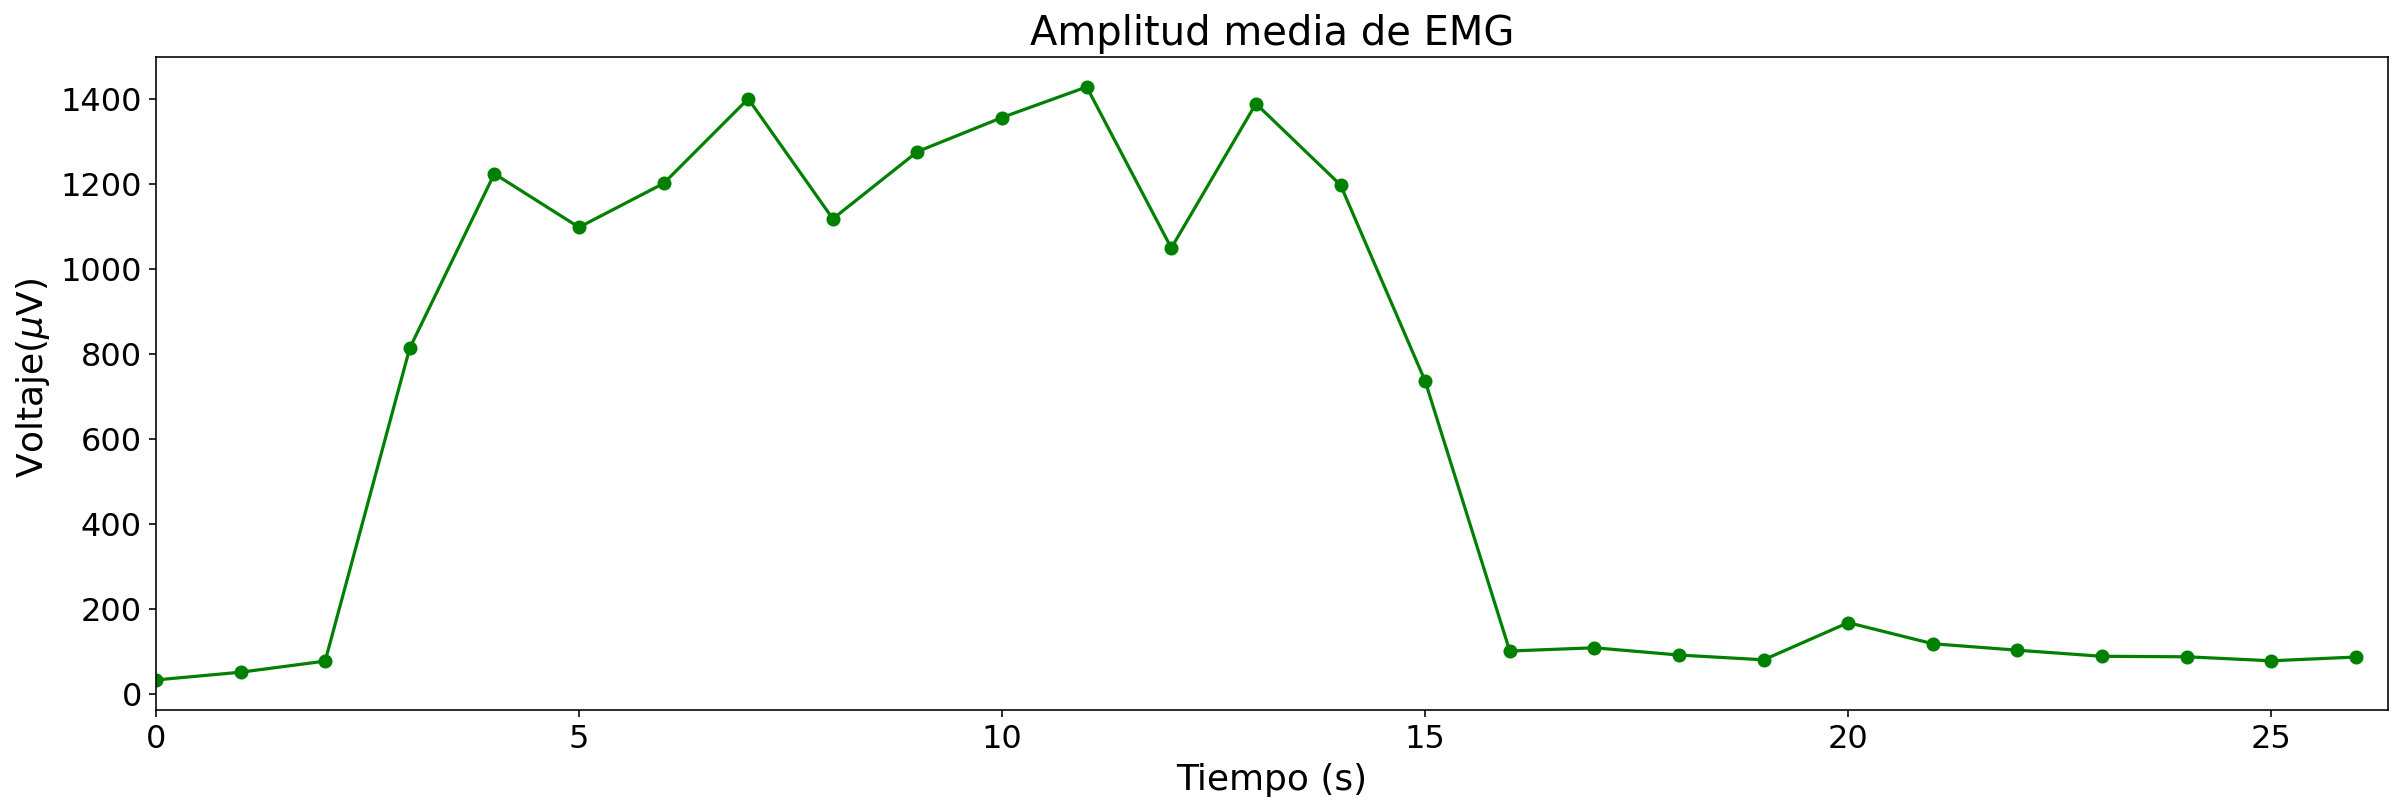

In [122]:
#Calculo de la amplitud media de los contenedores
meanamps = []
for n in range(0,len(x)):
    meanAmp=y[min(x[n]):max(x[n])].mean()
    meanamps.append(meanAmp)

# Trazamos los resultados 
plt.figure(figsize=(20,6))
plt.plot(meanamps,'o-', color='green')
plt.title('Amplitud media de EMG')
plt.xlabel('Tiempo (s)')
plt.xlim(0,max(SeñalRelevante['EMGtiempo']))  
plt.ylabel(' Voltaje($\mu$V)');

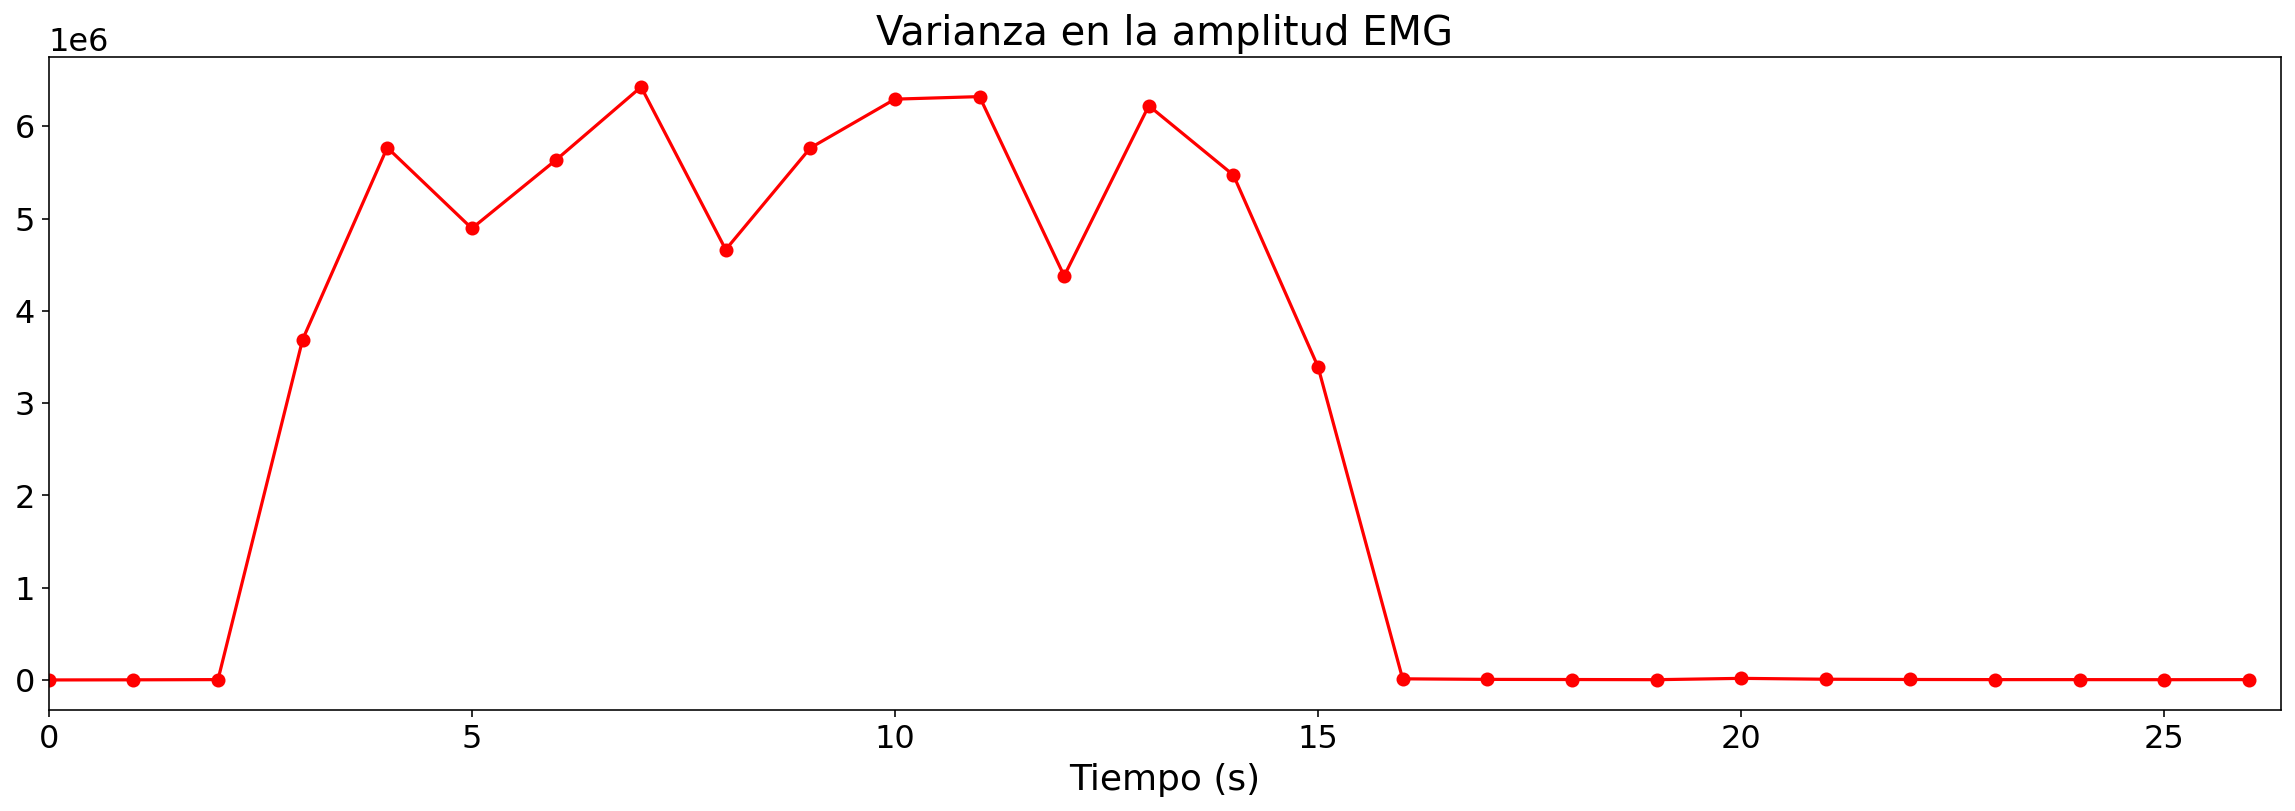

In [123]:
varamps = []
for n in range(0,len(x)):
    varAmp=y[min(x[n]):max(x[n])].var()
    varamps.append(varAmp)

# Trazamos los resultados
plt.figure(figsize=(20,6))
plt.plot(varamps,'o-',color='red')
plt.title('Varianza en la amplitud EMG')
plt.xlabel('Tiempo (s)')
plt.xlim(0,max(SeñalRelevante['EMGtiempo']));

### Referencias

Registros recuperados del repositorio elaborado por la Dra.Erin C. McKiernan y colaboradores, consultado en:
https://github.com/emckiernan/electrophys

Este trabajo fue apoyado por UNAM-DGAPA-PAPIME PE213817 y PE213219.